# 🎲 Simulation Basics - Understanding the Discrete Event Simulation

This notebook demonstrates the core simulation engine for the inventory system.

**Learning Goals:**
- 📦 Understand system components (Warehouse, Supplier, Customer, Logger)
- 🎯 Execute daily decisions and observe state transitions
- 📊 Track events through the built-in logger
- 💥 See stockouts happen when inventory runs out

**Architecture:**
```
InventorySimulation
├── Warehouse: Tracks inventory state
├── SupplierManager: Handles orders and deliveries
├── CustomerGenerator: Generates demand events
└── SimulationLogger: Records all events
```

In [1]:
import sys
sys.path.insert(0, '../..')

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 4)

## Part 1: System Parameters

The assignment defines two products with different demand patterns and lead times.

In [2]:
from src.simulation import create_product_0, create_product_1

product_0 = create_product_0()
product_1 = create_product_1()

print("📦 PRODUCT PARAMETERS")
print("=" * 50)

print("\n🛒 Product 0:")
print(f"   Expected demand: {product_0.expected_demand:.2f} units/customer")
print(f"   Lead time: {product_0.expected_lead_time:.1f} days (mean)")
print(f"   Lead time range: {product_0.lead_time_min}-{product_0.lead_time_max} days")

print("\n🛒 Product 1:")
print(f"   Expected demand: {product_1.expected_demand:.2f} units/customer")
print(f"   Lead time: {product_1.expected_lead_time:.1f} days (mean)")
print(f"   Lead time range: {product_1.lead_time_min}-{product_1.lead_time_max} days")

print("\n👥 Customer Arrivals:")
print(f"   Rate (λ): 0.1 customers/day")
print(f"   Mean inter-arrival time: 10 days")
print("   Distribution: Exponential")

print("\n💡 Key Insights:")
print(f"   • Product 1 has HIGHER demand ({product_1.expected_demand:.1f} vs {product_0.expected_demand:.1f})")
print(f"   • Product 1 has FASTER delivery ({product_1.expected_lead_time:.1f} vs {product_0.expected_lead_time:.1f} days)")
print("   • Both have uncertain, random lead times")

📦 PRODUCT PARAMETERS

🛒 Product 0:
   Expected demand: 2.50 units/customer
   Lead time: 22.5 days (mean)
   Lead time range: 15.0-30.0 days

🛒 Product 1:
   Expected demand: 3.62 units/customer
   Lead time: 13.5 days (mean)
   Lead time range: 6.0-21.0 days

👥 Customer Arrivals:
   Rate (λ): 0.1 customers/day
   Mean inter-arrival time: 10 days
   Distribution: Exponential

💡 Key Insights:
   • Product 1 has HIGHER demand (3.6 vs 2.5)
   • Product 1 has FASTER delivery (13.5 vs 22.5 days)
   • Both have uncertain, random lead times


### Visualize Demand Distributions

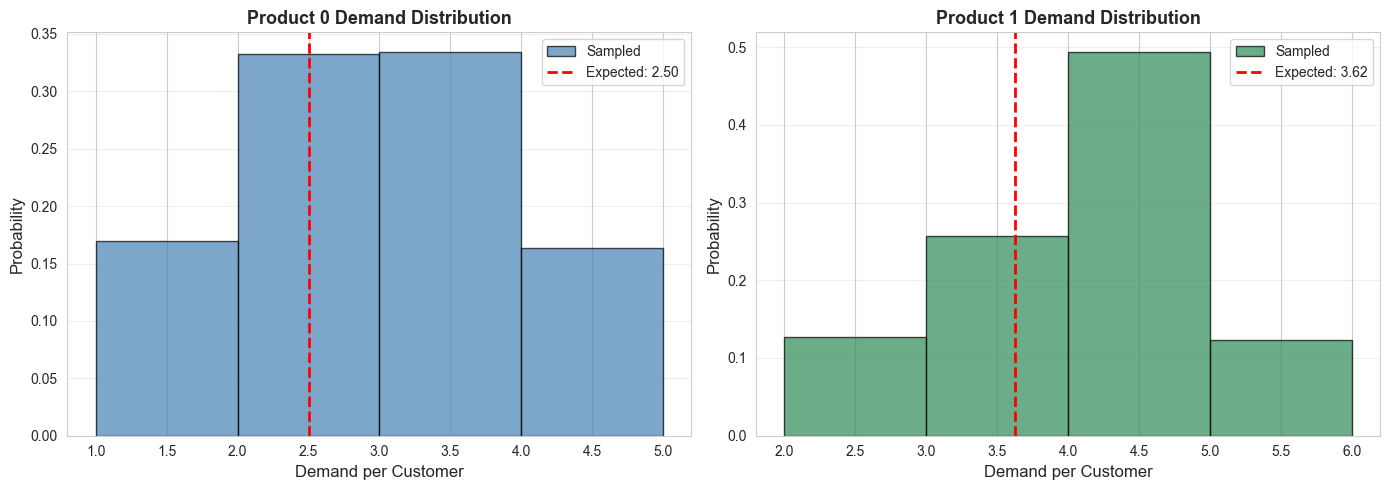

✓ Sampled 10,000 customers to verify distributions


In [3]:
# Sample demand distributions
rng = np.random.default_rng(42)
n_samples = 10000

demands_0 = [product_0.sample_demand(rng) for _ in range(n_samples)]
demands_1 = [product_1.sample_demand(rng) for _ in range(n_samples)]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Product 0 demand
axes[0].hist(demands_0, bins=range(1, 6), density=True, 
             alpha=0.7, edgecolor='black', color='steelblue', label='Sampled')
axes[0].axvline(product_0.expected_demand, color='red', linestyle='--', 
                linewidth=2, label=f'Expected: {product_0.expected_demand:.2f}')
axes[0].set_xlabel('Demand per Customer', fontsize=12)
axes[0].set_ylabel('Probability', fontsize=12)
axes[0].set_title('Product 0 Demand Distribution', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# Product 1 demand
axes[1].hist(demands_1, bins=range(2, 7), density=True,
             alpha=0.7, edgecolor='black', color='seagreen', label='Sampled')
axes[1].axvline(product_1.expected_demand, color='red', linestyle='--',
                linewidth=2, label=f'Expected: {product_1.expected_demand:.2f}')
axes[1].set_xlabel('Demand per Customer', fontsize=12)
axes[1].set_ylabel('Probability', fontsize=12)
axes[1].set_title('Product 1 Demand Distribution', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"✓ Sampled {n_samples:,} customers to verify distributions")

## Part 2: Creating and Running the Simulation

The `InventorySimulation` class orchestrates all components.

In [4]:
from src.simulation import InventorySimulation
from src.mdp import create_state, order_both_products

# Create simulation engine
sim = InventorySimulation(random_state=rng)

# Reset to initial state (defaults to empty warehouse)
sim.reset()  # Same as: sim.reset(create_state(0, 0, 0, 0))

print("🏭 SIMULATION INITIALIZED")
print("=" * 50)

# Get initial state from warehouse
initial_state = sim.get_current_state()
print(f"\nInitial State:")
print(f"  Net inventory: {initial_state.net_inventory}")
print(f"  Outstanding orders: {initial_state.outstanding_orders}")
print(f"  Current day: {sim.current_day}")

print("\n✓ Empty warehouse - need to place orders!")
print("✓ Simulation ready to execute daily decisions")

🏭 SIMULATION INITIALIZED

Initial State:
  Net inventory: (0, 0)
  Outstanding orders: (0, 0)
  Current day: 0

✓ Empty warehouse - need to place orders!
✓ Simulation ready to execute daily decisions


## Part 3: Execute One Daily Decision

The main simulation loop: place orders → simulate one day → get new state.

In [5]:
# Decision: Order 15 units of each product
action = order_both_products(15, 15)

print("📋 DAILY DECISION EXECUTION")
print("=" * 50)
print(f"\nDay {sim.current_day}: Placing orders")
print(f"  Action: Order {action.order_quantities}")

# Execute the decision (place orders, simulate 1 day, return new state)
next_state, info = sim.execute_daily_decision(action)

print(f"\nDay {sim.current_day} - After Simulation:")
print(f"  Net inventory: {next_state.net_inventory}")
print(f"  Outstanding orders: {next_state.outstanding_orders}")

print("\n📊 Events that occurred:")
print(f"  Customers arrived: {info['num_customers']}")
print(f"  Total demand: {info['total_demand']}")
print(f"  Orders arrived: {info['num_order_arrivals']}")

print("\n💡 What Happened:")
print("  1. We placed orders (15, 15) → outstanding increased")
print(f"  2. During the day, {info['num_customers']} customer(s) arrived")
print(f"  3. They demanded {info['total_demand']} units")
print("  4. Net inventory decreased by demand (likely negative - stockout!)")
print(f"  5. Some orders may have arrived: {info['num_order_arrivals']}")

📋 DAILY DECISION EXECUTION

Day 0: Placing orders
  Action: Order (15, 15)

Day 1 - After Simulation:
  Net inventory: (-2, -4)
  Outstanding orders: (15, 15)

📊 Events that occurred:
  Customers arrived: 1
  Total demand: (2, 4)
  Orders arrived: (0, 0)

💡 What Happened:
  1. We placed orders (15, 15) → outstanding increased
  2. During the day, 1 customer(s) arrived
  3. They demanded (2, 4) units
  4. Net inventory decreased by demand (likely negative - stockout!)
  5. Some orders may have arrived: (0, 0)


## Part 4: Multi-Day Simulation with Simple Policy

Run 30 days with a basic reorder point policy.

In [6]:
from src.mdp import State

# Reset simulation
sim = InventorySimulation(random_state=np.random.default_rng(123))
sim.reset()  # Start from empty warehouse

# Simple reorder point policy
def simple_reorder_policy(state: State, reorder_point: int = 15, order_quantity: int = 10):
    """Order if inventory position drops below reorder point."""
    q0 = order_quantity if state.get_inventory_position(0) < reorder_point else 0
    q1 = order_quantity if state.get_inventory_position(1) < reorder_point else 0
    return order_both_products(q0, q1)

# Simulate 30 days
num_days = 30
for day in range(num_days):
    current_state = sim.get_current_state()
    action = simple_reorder_policy(current_state)
    next_state, _ = sim.execute_daily_decision(action)

# Extract data from logger
all_stats = sim.logger.get_all_statistics()

print(f"✓ Simulated {len(all_stats)} days")
print(f"  Total customers: {sum(s.num_customers for s in all_stats)}")
print(f"  Total demand (prod 0): {sum(s.total_demand_per_product.get(0, 0) for s in all_stats)}")
print(f"  Total demand (prod 1): {sum(s.total_demand_per_product.get(1, 0) for s in all_stats)}")

✓ Simulated 29 days
  Total customers: 5
  Total demand (prod 0): 16
  Total demand (prod 1): 16


### Visualize System Evolution

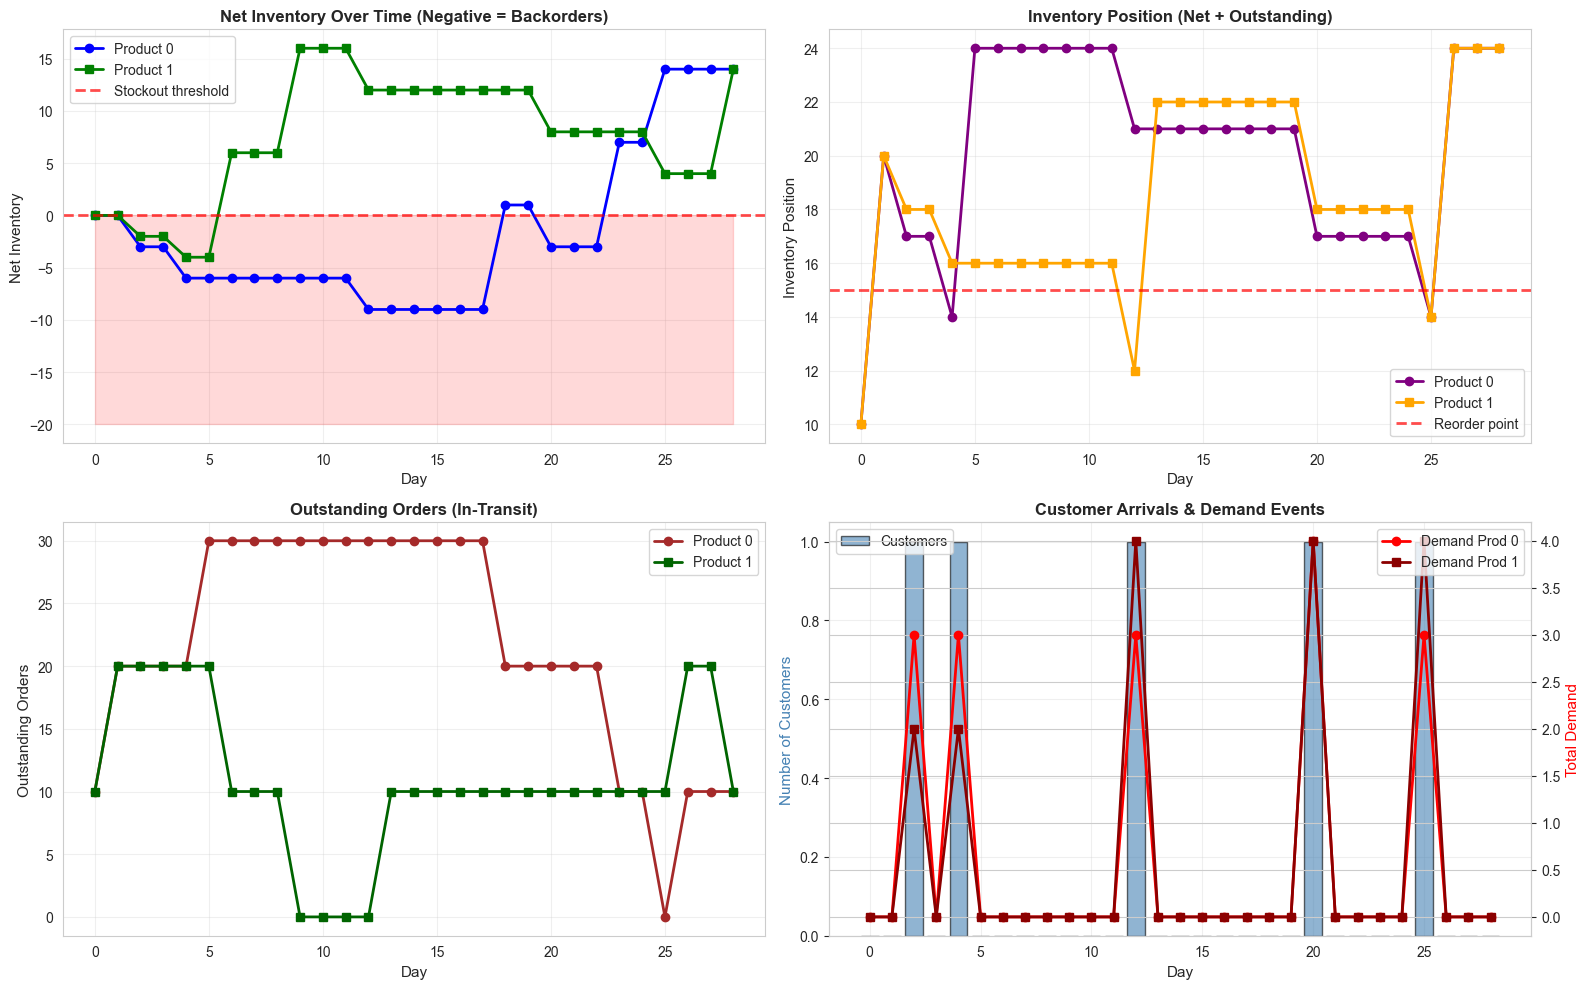


✅ Key Observations:
  • Net inventory goes NEGATIVE when we run out of stock (backorders)
  • Inventory position = net + outstanding (accounts for in-transit orders)
  • Policy orders when inventory position < 15
  • Outstanding orders fluctuate as orders are placed and arrive
  • Customer arrivals are random (sparse - ~0.1 per day)

💡 All data from sim.logger - no manual tracking needed!


In [7]:
# Extract data from logger
days = [s.day for s in all_stats]
net_inv_0 = [s.net_inventory_per_product.get(0, 0) for s in all_stats]
net_inv_1 = [s.net_inventory_per_product.get(1, 0) for s in all_stats]
outstanding_0 = [s.outstanding_per_product.get(0, 0) for s in all_stats]
outstanding_1 = [s.outstanding_per_product.get(1, 0) for s in all_stats]
customers = [s.num_customers for s in all_stats]
demand_0 = [s.total_demand_per_product.get(0, 0) for s in all_stats]
demand_1 = [s.total_demand_per_product.get(1, 0) for s in all_stats]

# Calculate inventory position
inv_pos_0 = [net + out for net, out in zip(net_inv_0, outstanding_0)]
inv_pos_1 = [net + out for net, out in zip(net_inv_1, outstanding_1)]

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Net Inventory (can go negative!)
axes[0, 0].plot(days, net_inv_0, marker='o', linewidth=2, label='Product 0', color='blue')
axes[0, 0].plot(days, net_inv_1, marker='s', linewidth=2, label='Product 1', color='green')
axes[0, 0].axhline(0, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Stockout threshold')
axes[0, 0].fill_between(days, -20, 0, alpha=0.15, color='red')
axes[0, 0].set_xlabel('Day', fontsize=11)
axes[0, 0].set_ylabel('Net Inventory', fontsize=11)
axes[0, 0].set_title('Net Inventory Over Time (Negative = Backorders)', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Inventory Position (Net + Outstanding)
axes[0, 1].plot(days, inv_pos_0, marker='o', linewidth=2, label='Product 0', color='purple')
axes[0, 1].plot(days, inv_pos_1, marker='s', linewidth=2, label='Product 1', color='orange')
axes[0, 1].axhline(15, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Reorder point')
axes[0, 1].set_xlabel('Day', fontsize=11)
axes[0, 1].set_ylabel('Inventory Position', fontsize=11)
axes[0, 1].set_title('Inventory Position (Net + Outstanding)', fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Outstanding Orders (in-transit)
axes[1, 0].plot(days, outstanding_0, marker='o', linewidth=2, label='Product 0', color='brown')
axes[1, 0].plot(days, outstanding_1, marker='s', linewidth=2, label='Product 1', color='darkgreen')
axes[1, 0].set_xlabel('Day', fontsize=11)
axes[1, 0].set_ylabel('Outstanding Orders', fontsize=11)
axes[1, 0].set_title('Outstanding Orders (In-Transit)', fontsize=12, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Customer Arrivals & Demand
ax_twin = axes[1, 1].twinx()
axes[1, 1].bar(days, customers, alpha=0.6, color='steelblue', label='Customers', edgecolor='black')
ax_twin.plot(days, demand_0, marker='o', color='red', linewidth=2, label='Demand Prod 0')
ax_twin.plot(days, demand_1, marker='s', color='darkred', linewidth=2, label='Demand Prod 1')
axes[1, 1].set_xlabel('Day', fontsize=11)
axes[1, 1].set_ylabel('Number of Customers', fontsize=11, color='steelblue')
ax_twin.set_ylabel('Total Demand', fontsize=11, color='red')
axes[1, 1].set_title('Customer Arrivals & Demand Events', fontsize=12, fontweight='bold')
axes[1, 1].legend(loc='upper left')
ax_twin.legend(loc='upper right')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ Key Observations:")
print("  • Net inventory goes NEGATIVE when we run out of stock (backorders)")
print("  • Inventory position = net + outstanding (accounts for in-transit orders)")
print("  • Policy orders when inventory position < 15")
print("  • Outstanding orders fluctuate as orders are placed and arrive")
print("  • Customer arrivals are random (sparse - ~0.1 per day)")
print("\n💡 All data from sim.logger - no manual tracking needed!")

## Part 5: Understanding the Logger

The `SimulationLogger` tracks all events automatically.

In [8]:
# Examine a specific day's statistics
day_10_stats = all_stats[10]  # Day 10 (0-indexed)

print("📊 DAY 10 STATISTICS")
print("=" * 50)
print(f"Day: {day_10_stats.day}")
print(f"\n📦 Inventory State:")
print(f"  Net inventory: {dict(day_10_stats.net_inventory_per_product)}")
print(f"  Outstanding orders: {dict(day_10_stats.outstanding_per_product)}")

print(f"\n👥 Customer Events:")
print(f"  Customers arrived: {day_10_stats.num_customers}")
print(f"  Total demand: {dict(day_10_stats.total_demand_per_product)}")

print(f"\n📦 Order Events:")
print(f"  Orders placed: {dict(day_10_stats.outstanding_per_product)}")
print(f"  Orders arrived: {dict(day_10_stats.num_order_arrivals_per_product)}")

print("\n💡 The logger tracks:")
print("  ✓ Inventory state at each decision epoch")
print("  ✓ Customer arrival events and demands")
print("  ✓ Order placement and arrival events")
print("  ✓ All data organized by day and product")

📊 DAY 10 STATISTICS
Day: 10

📦 Inventory State:
  Net inventory: {0: -6, 1: 16}
  Outstanding orders: {0: 30, 1: 0}

👥 Customer Events:
  Customers arrived: 0
  Total demand: {0: 0, 1: 0}

📦 Order Events:
  Orders placed: {0: 30, 1: 0}
  Orders arrived: {0: 0, 1: 0}

💡 The logger tracks:
  ✓ Inventory state at each decision epoch
  ✓ Customer arrival events and demands
  ✓ Order placement and arrival events
  ✓ All data organized by day and product


## Part 6: Stockout Scenario

What happens when we don't order enough?

In [9]:
# Reset and run WITHOUT ordering
sim_stockout = InventorySimulation(random_state=np.random.default_rng(999))
sim_stockout.reset()  # Empty warehouse

print("🚨 STOCKOUT SIMULATION - NO ORDERING")
print("=" * 50)

# Run 30 days WITHOUT placing any orders
for day in range(30):
    action = order_both_products(0, 0)  # NO ORDERS!
    state, info = sim_stockout.execute_daily_decision(action)
    
    # Print when stockout occurs
    if state.net_inventory[0] < 0 or state.net_inventory[1] < 0:
        print(f"Day {day}: 💥 STOCKOUT! Net inv = {state.net_inventory}")

stockout_stats = sim_stockout.logger.get_all_statistics()
print(f"\n✓ Simulated {len(stockout_stats)} days with NO ordering policy")

🚨 STOCKOUT SIMULATION - NO ORDERING
Day 16: 💥 STOCKOUT! Net inv = (-2, -3)
Day 17: 💥 STOCKOUT! Net inv = (-2, -3)
Day 18: 💥 STOCKOUT! Net inv = (-2, -3)
Day 19: 💥 STOCKOUT! Net inv = (-2, -3)
Day 20: 💥 STOCKOUT! Net inv = (-2, -3)
Day 21: 💥 STOCKOUT! Net inv = (-2, -3)
Day 22: 💥 STOCKOUT! Net inv = (-2, -3)
Day 23: 💥 STOCKOUT! Net inv = (-2, -3)
Day 24: 💥 STOCKOUT! Net inv = (-2, -3)
Day 25: 💥 STOCKOUT! Net inv = (-2, -3)
Day 26: 💥 STOCKOUT! Net inv = (-2, -3)
Day 27: 💥 STOCKOUT! Net inv = (-2, -3)
Day 28: 💥 STOCKOUT! Net inv = (-4, -5)
Day 29: 💥 STOCKOUT! Net inv = (-4, -5)

✓ Simulated 29 days with NO ordering policy


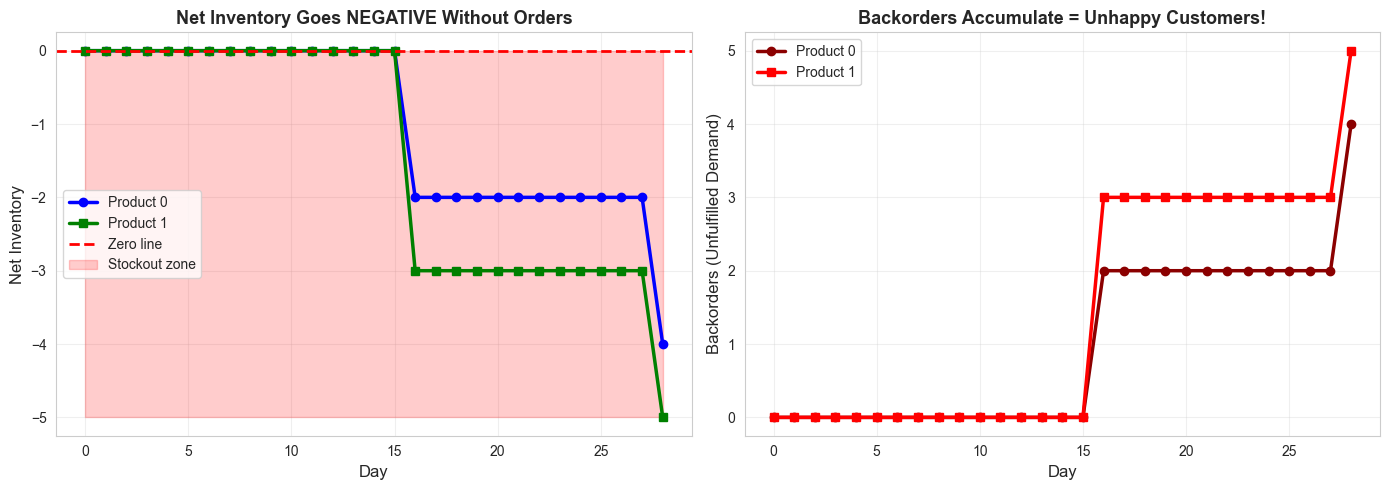


💰 Cost Impact:
   Backorder cost (π): $7.0/unit/day
   Holding cost (h): $1.0/unit/day
   Ratio: π/h = 7.0x

💡 Backorders are 7x more expensive than holding inventory!
   This is why we need a good ordering policy.


In [10]:
# Visualize stockout scenario
days = [s.day for s in stockout_stats]
net_inv_0 = [s.net_inventory_per_product.get(0, 0) for s in stockout_stats]
net_inv_1 = [s.net_inventory_per_product.get(1, 0) for s in stockout_stats]

# Calculate backorders (negative inventory)
backorders_0 = [max(0, -inv) for inv in net_inv_0]
backorders_1 = [max(0, -inv) for inv in net_inv_1]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Net inventory plummeting
axes[0].plot(days, net_inv_0, marker='o', linewidth=2.5, label='Product 0', color='blue')
axes[0].plot(days, net_inv_1, marker='s', linewidth=2.5, label='Product 1', color='green')
axes[0].axhline(0, color='red', linestyle='--', linewidth=2, label='Zero line')
axes[0].fill_between(days, min(net_inv_0 + net_inv_1), 0, alpha=0.2, color='red', label='Stockout zone')
axes[0].set_xlabel('Day', fontsize=12)
axes[0].set_ylabel('Net Inventory', fontsize=12)
axes[0].set_title('Net Inventory Goes NEGATIVE Without Orders', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Backorders accumulating
axes[1].plot(days, backorders_0, marker='o', linewidth=2.5, label='Product 0', color='darkred')
axes[1].plot(days, backorders_1, marker='s', linewidth=2.5, label='Product 1', color='red')
axes[1].set_xlabel('Day', fontsize=12)
axes[1].set_ylabel('Backorders (Unfulfilled Demand)', fontsize=12)
axes[1].set_title('Backorders Accumulate = Unhappy Customers!', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

from src.mdp import CostParameters

print(f"\n💰 Cost Impact:")
print(f"   Backorder cost (π): ${CostParameters.pi}/unit/day")
print(f"   Holding cost (h): ${CostParameters.h}/unit/day")
print(f"   Ratio: π/h = {CostParameters.pi/CostParameters.h:.1f}x")
print("\n💡 Backorders are 7x more expensive than holding inventory!")
print("   This is why we need a good ordering policy.")

## 🎯 Summary

**What You Learned:**

### 1. **Simulation Architecture**
- `InventorySimulation` orchestrates all components
- `Warehouse` tracks inventory state
- `SupplierManager` handles orders and lead times
- `CustomerGenerator` creates random demand
- `SimulationLogger` records everything

### 2. **State Dynamics**
- **Net Inventory**: Can be positive (stock) or negative (backorders)
- **Outstanding Orders**: Tracks in-transit inventory
- **Inventory Position**: Net + Outstanding (key for decision-making)

### 3. **Stochastic Events**
- Customer arrivals: Poisson process (λ = 0.1/day)
- Demand per customer: Discrete distribution per product
- Lead times: Uniform distribution [min, max] days

### 4. **Simulation Loop**
```python
sim.reset()  # Initialize
for day in range(horizon):
    state = sim.get_current_state()
    action = policy(state)  # Your decision
    next_state, info = sim.execute_daily_decision(action)
```

### 5. **Why Stockouts Are Bad**
- Net inventory < 0 = unhappy customers waiting
- Backorder cost (π=7) >> holding cost (h=1)
- Need intelligent ordering policy to balance costs

**Next Steps:**
- Implement baseline (s,S) policy
- Train RL agents to learn optimal policies
- Evaluate performance with cost metrics